In [1]:
# This notebook demonstrates a workflow for vessel extration that will work with most types of data.
# It will produce "good" results, despite being agnostic to the modality.
# It assumes that vessels are "bright" in the image

In [2]:
import os

import itk
from itk import TubeTK as tube

from itkwidgets import view

import numpy as np

In [3]:
InputBaseName = "../Data/MRI-Cases/mra-brain"

OutputBaseName = "./mra-brain-out"

InputFilename = InputBaseName+".mha"

imRaw = itk.imread(InputFilename, itk.F)


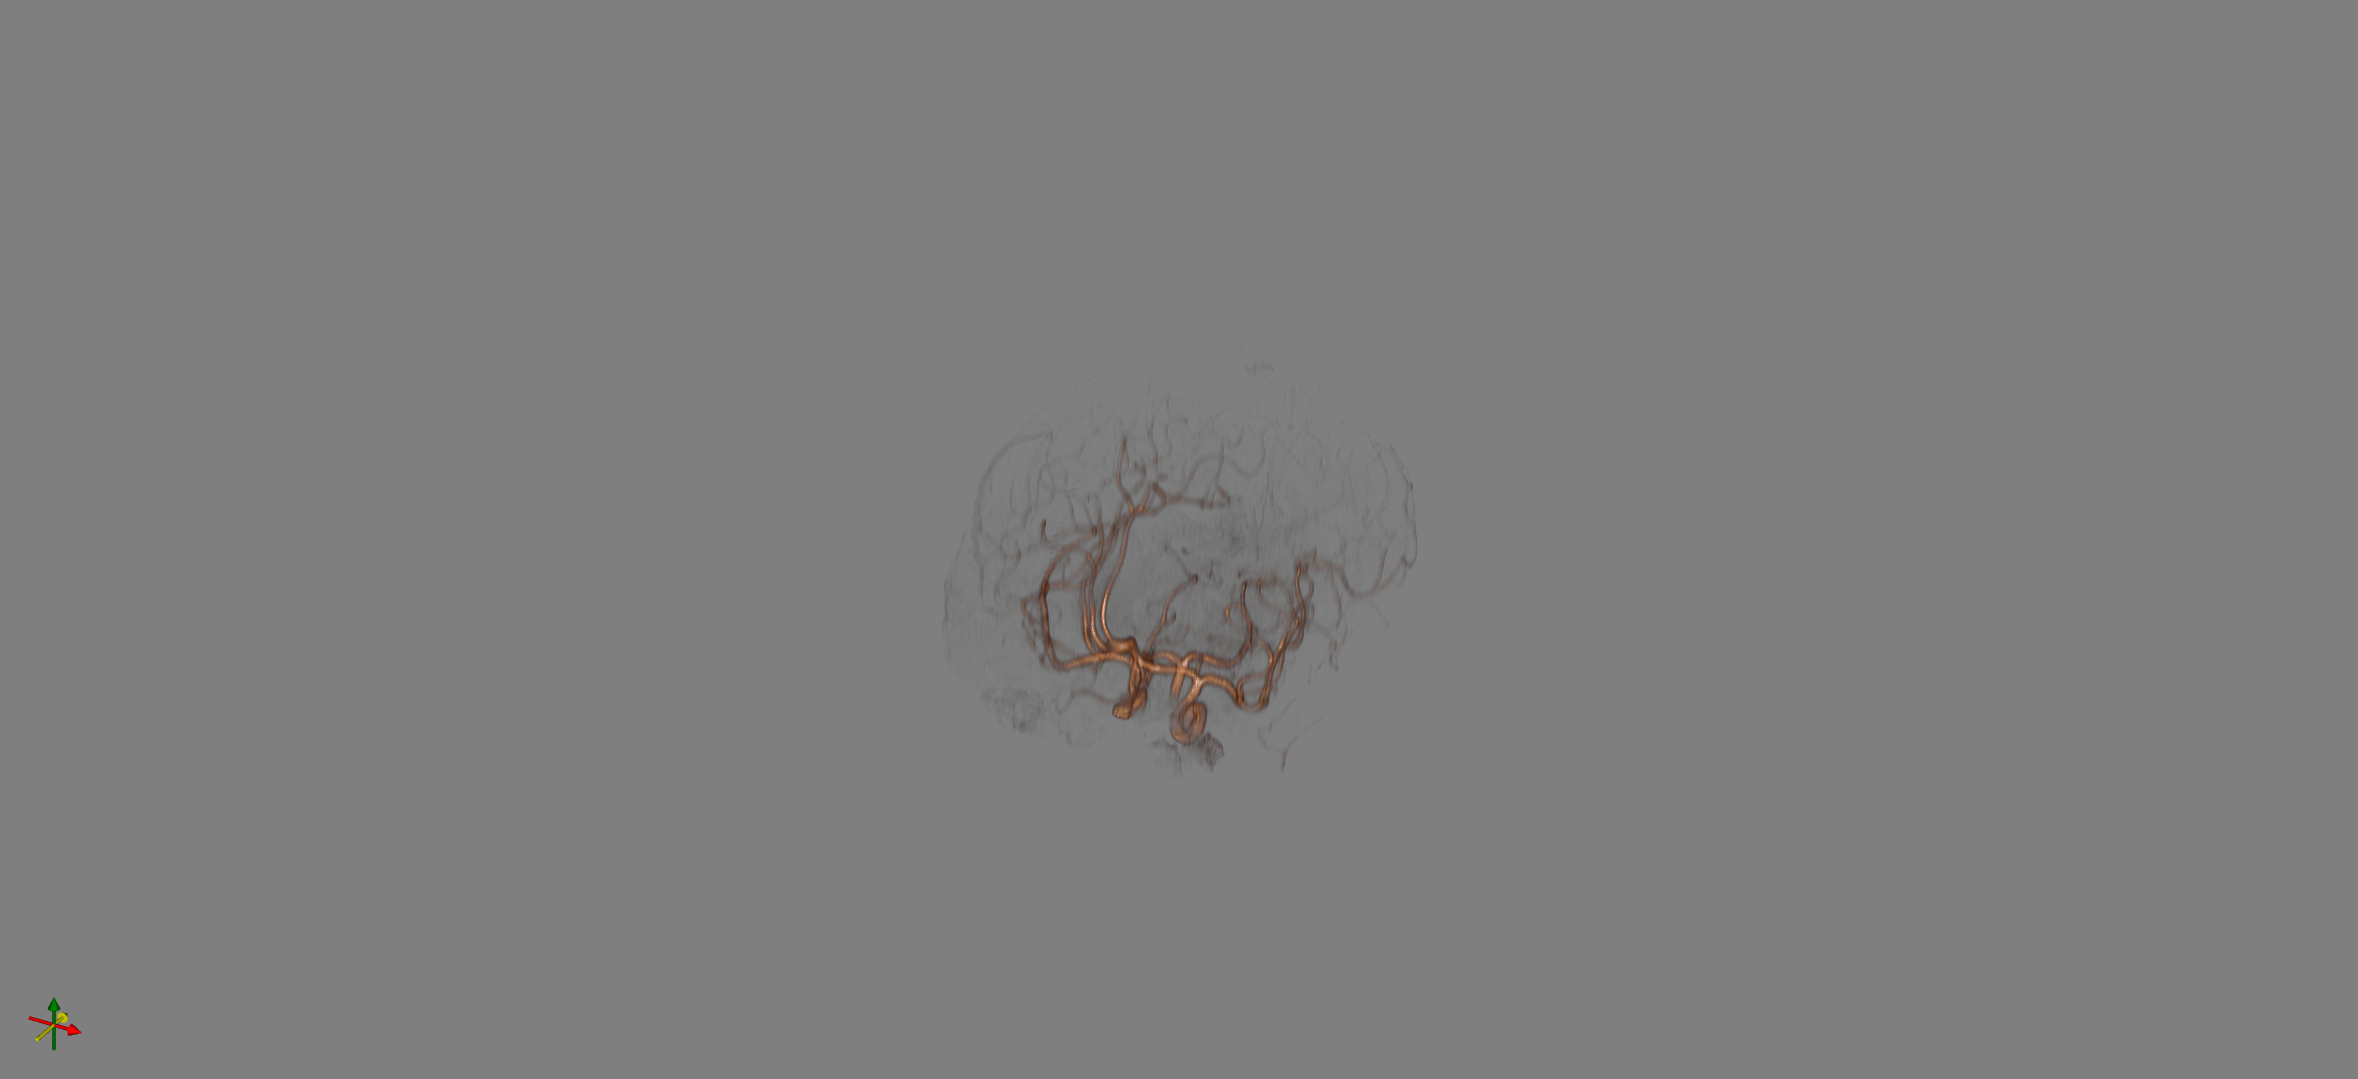
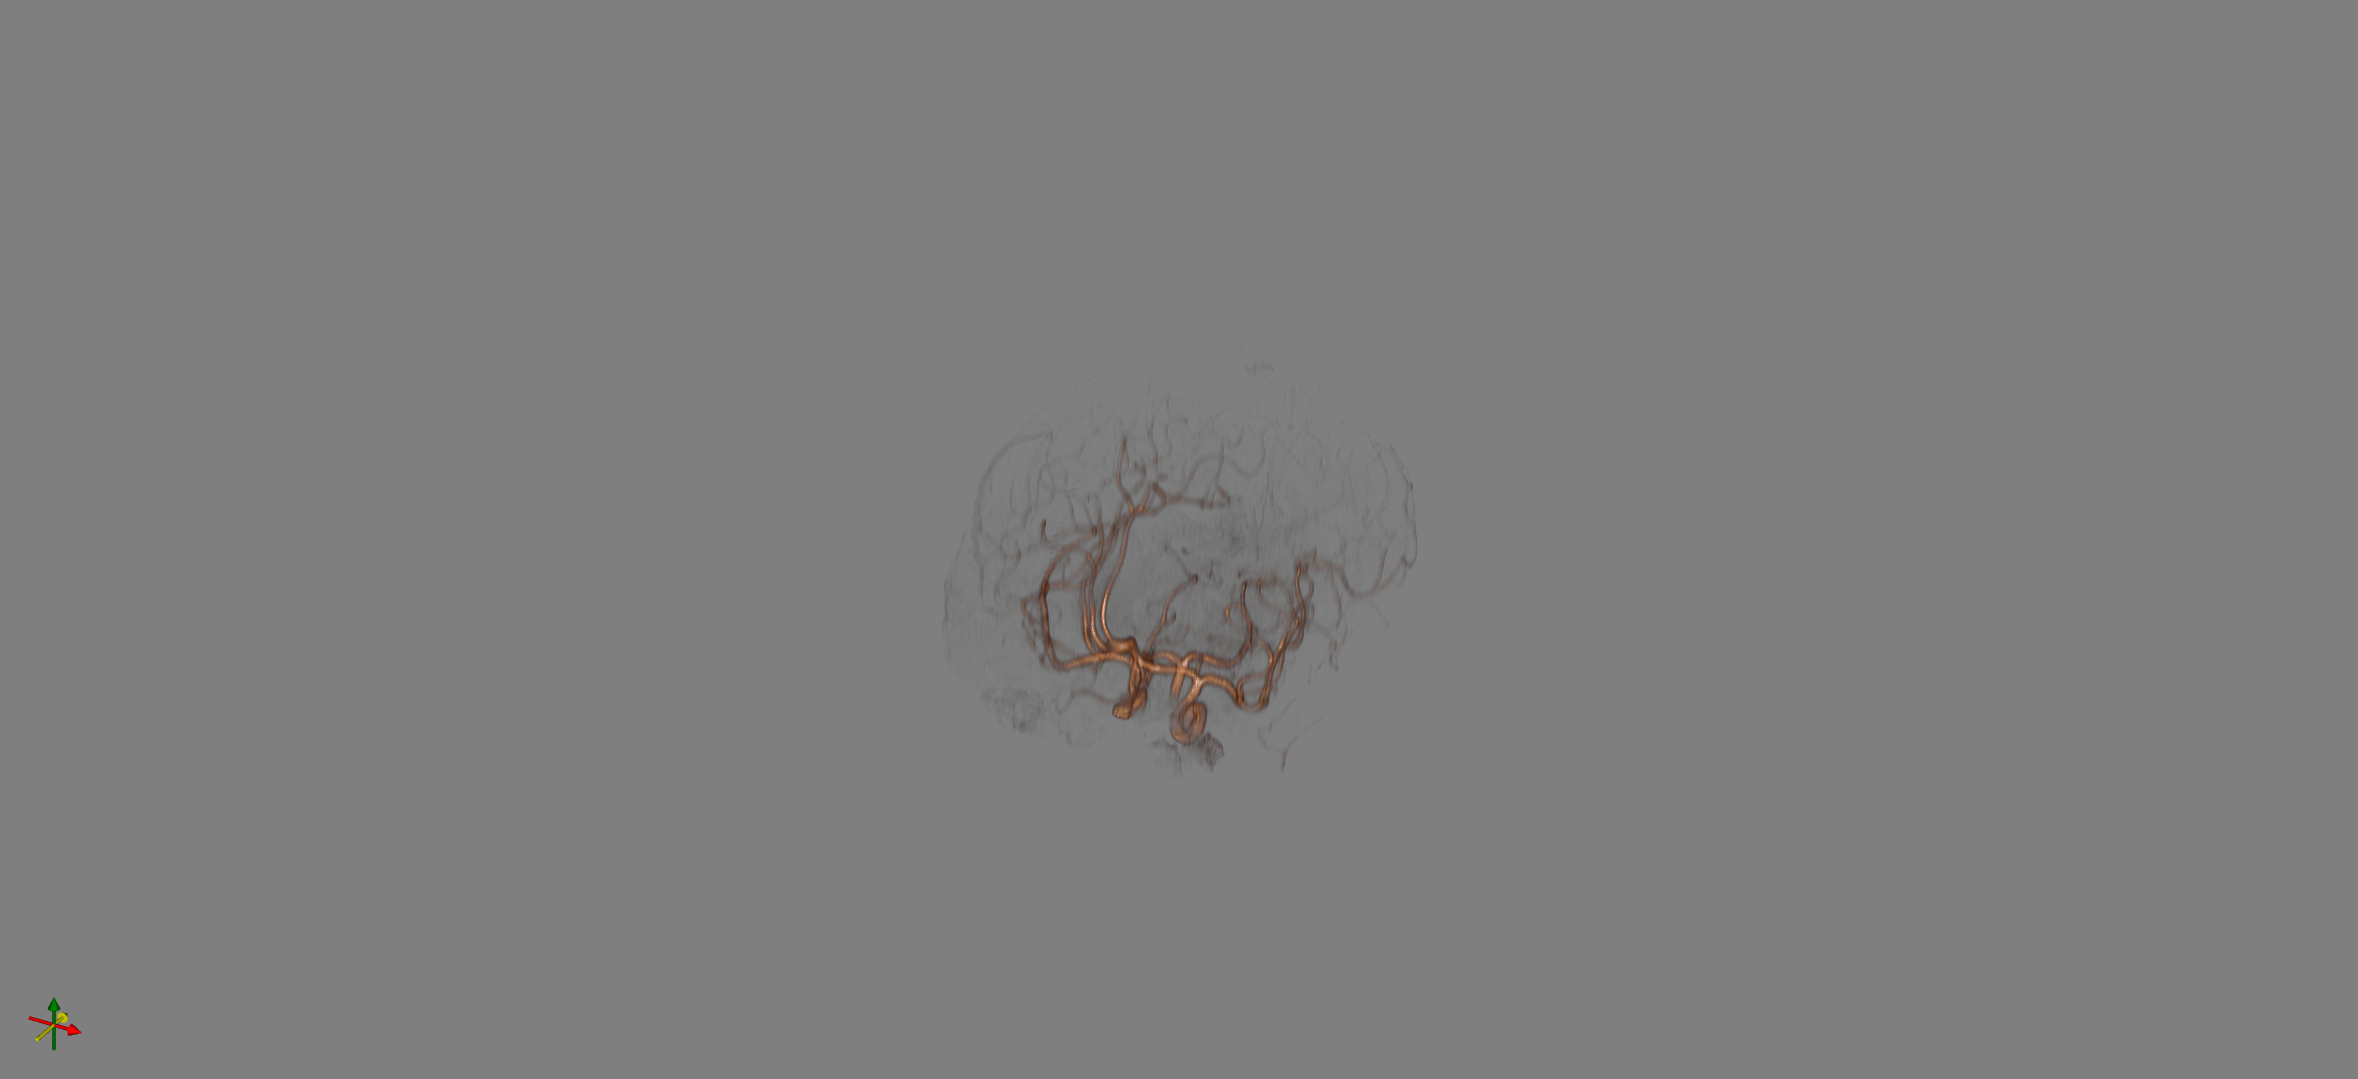

<IPython.core.display.Javascript object>

In [4]:
view(imRaw)

In [5]:
# Ensure the data has isotropic voxels to simplify 3D computations
resampler = tube.ResampleImage.New( Input=imRaw, MakeHighResIso=True )
resampler.Update()
im = resampler.GetOutput()

itkImageF4 not loaded from module TubeTK because of exception:
 module 'itk.TubeTKPython' has no attribute 'itkImageF4'
vectoritkImageF4 not loaded from module TubeTK because of exception:
 module 'itk.TubeTKPython' has no attribute 'vectoritkImageF4'


In [6]:
ImageType = itk.Image[itk.F, 3]

spacing = im.GetSpacing()[0]

imArray = itk.GetArrayFromImage(im)
im_min = float(imArray.min())
im_max = float(imArray.max())

print("Spacing:", spacing)
print("Intensity range:", im_min, "-", im_max)

Spacing: 0.419922
Intensity range: 0.0 - 455.6091613769531



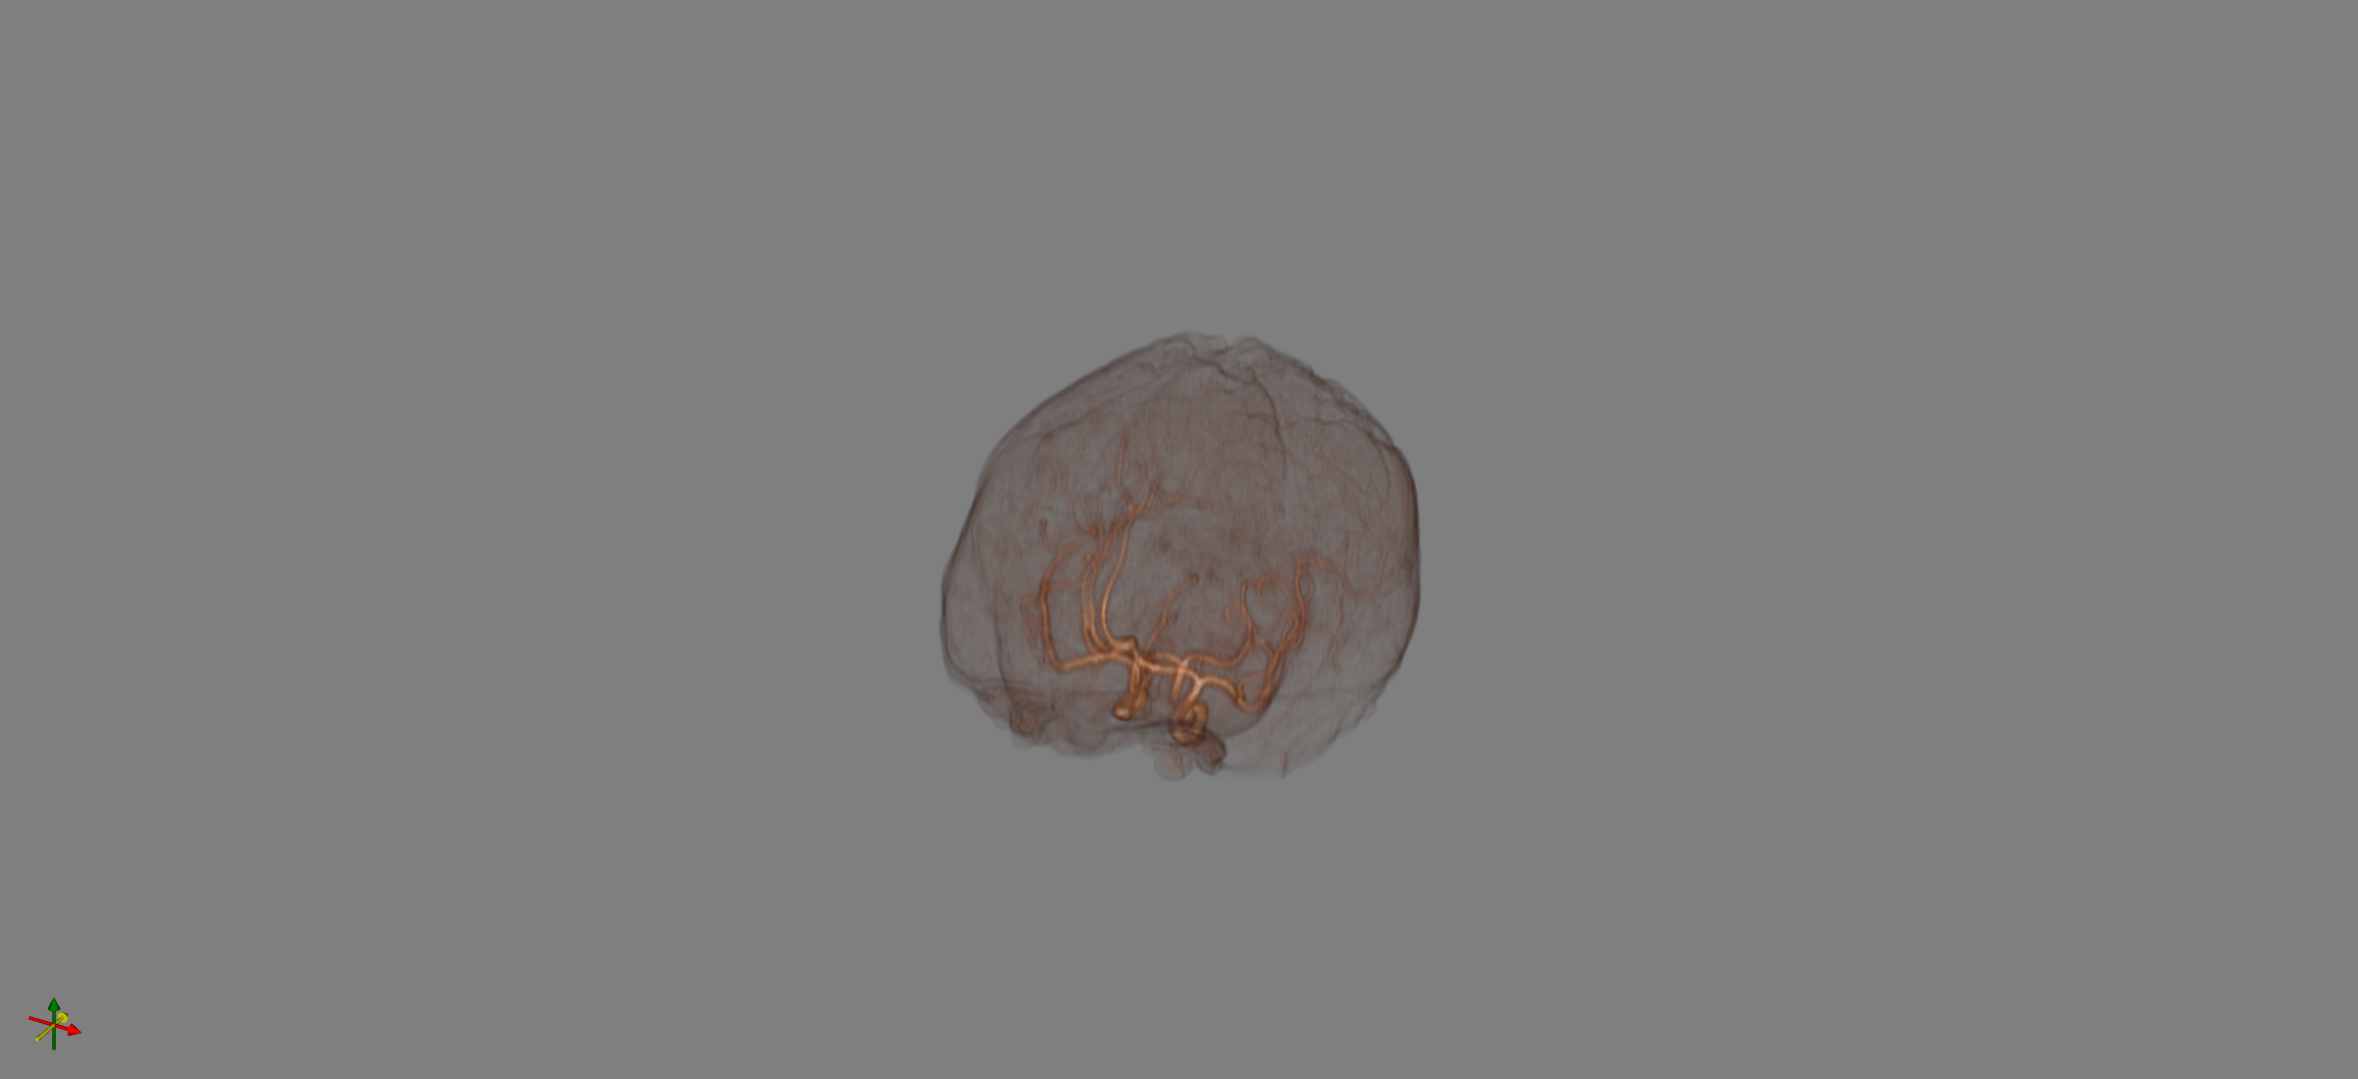
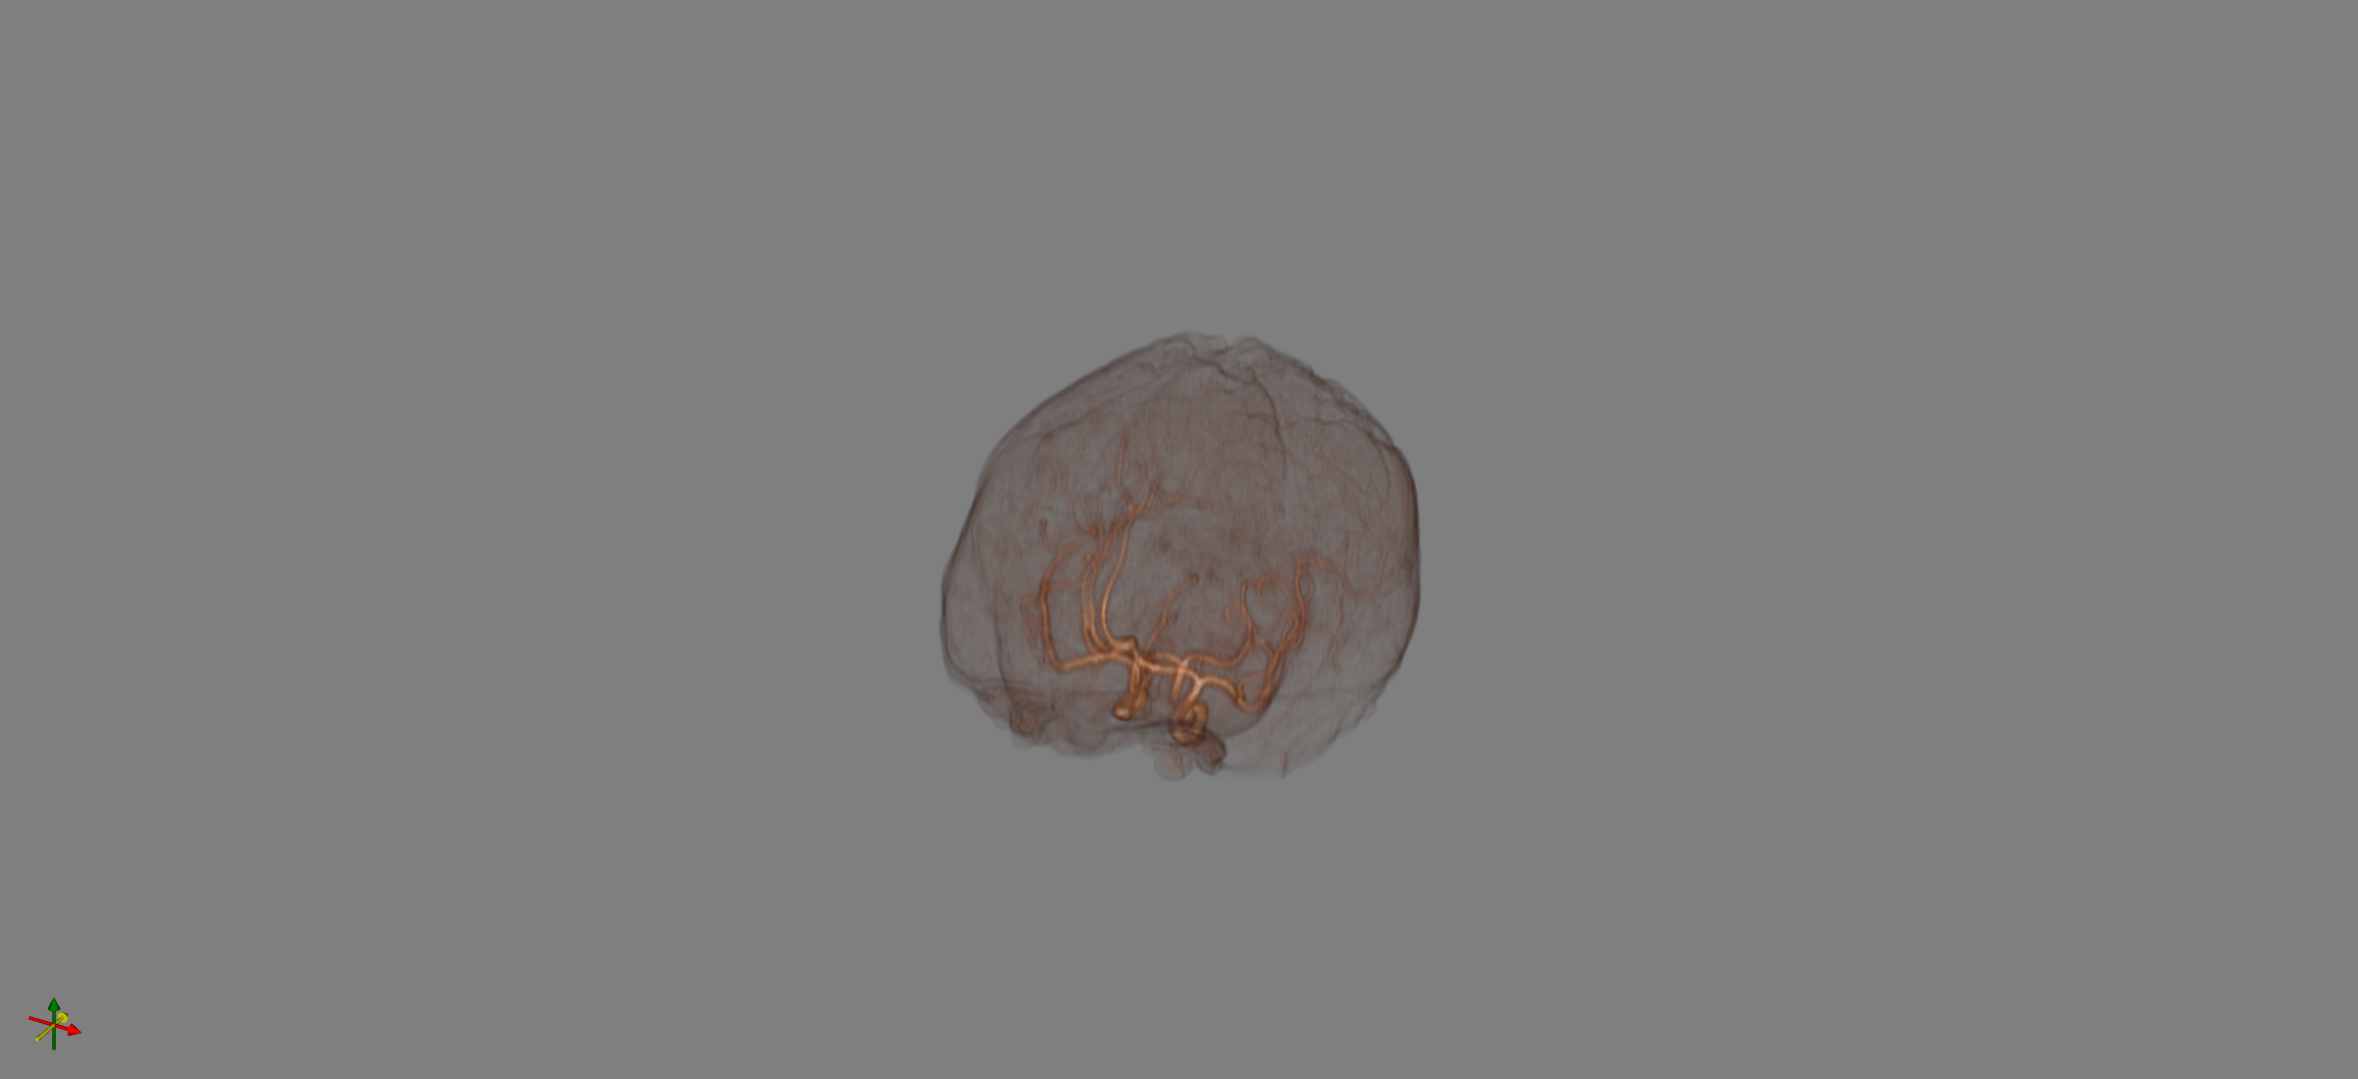

<IPython.core.display.Javascript object>

In [7]:
view(im)

In [8]:
# We use a difference of Gaussian (DoG) filtering of the data to identify vessel voxels that are less suseptical to
#   intensity variations across the image.
#   This does assume that vessels are at approximately the resolution of the image (e.g., typically have a diameter of 1 or 2 voxels.
#      This determines the size of the inner and outer gaussians used in the DoG filter.
#      If vessels have a wide range of sizes in your data, this step should be eliminated.
#   Note that the DoG filtered image is only used for seed point selection - not for extraction.  So it isn't critical.
imMath = tube.ImageMath.New(im)
imMath.IntensityWindow(im_min, im_max, 0.0, 1000.0)
imMath.Blur(0.34*spacing)  # Assume vessels near the inner scale of the image are of interest
imBlur = imMath.GetOutput()
imMath.Blur(2.35*spacing)  # Assume vessels near the inner scale of the image are of interest
imMath.AddImages(imBlur, -1, 1)
imDoG = imMath.GetOutput()

imDoGArray = itk.GetArrayFromImage(imDoG)


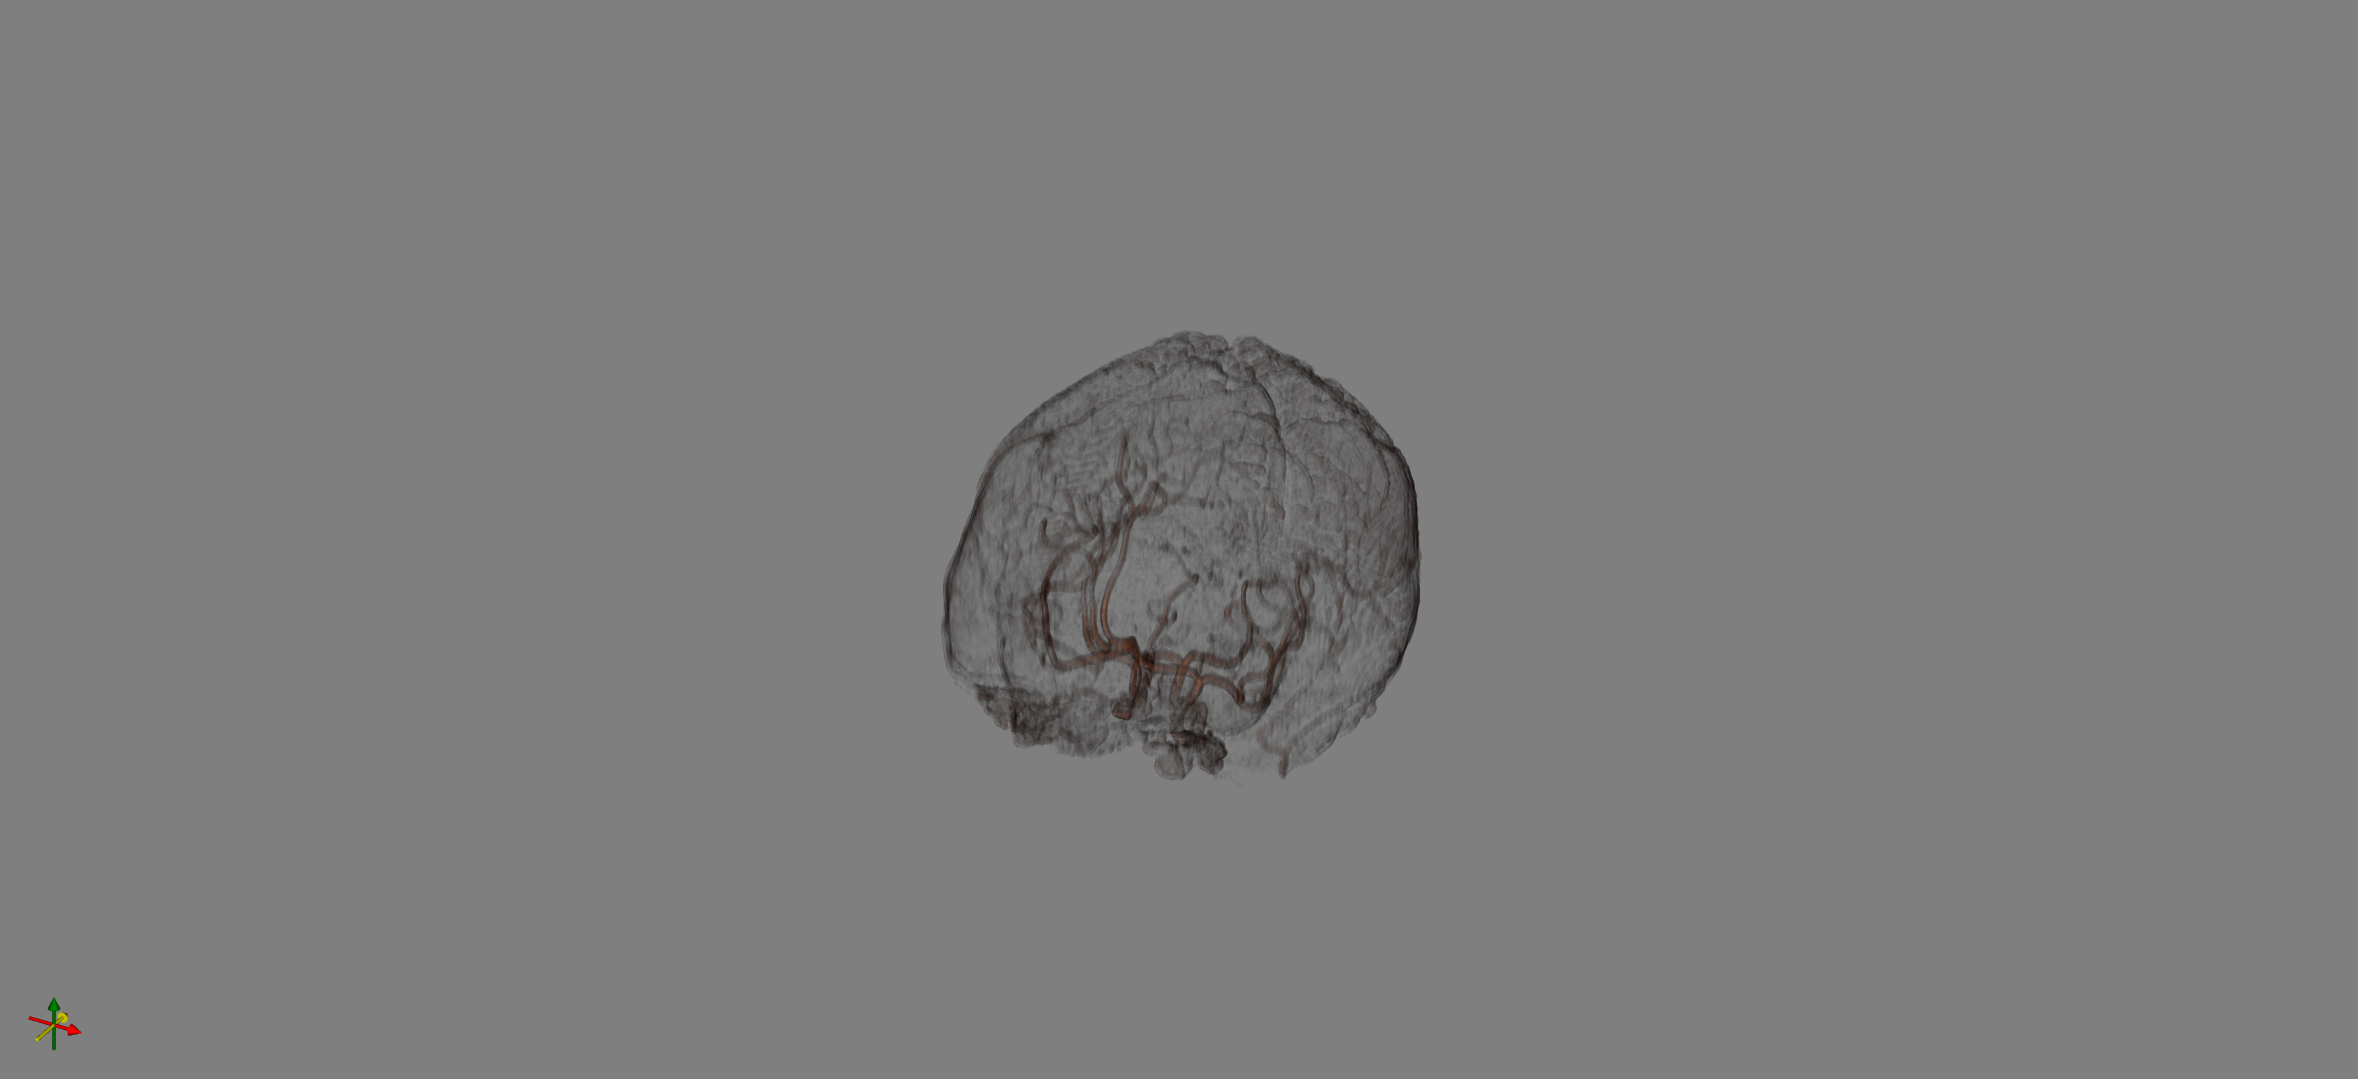
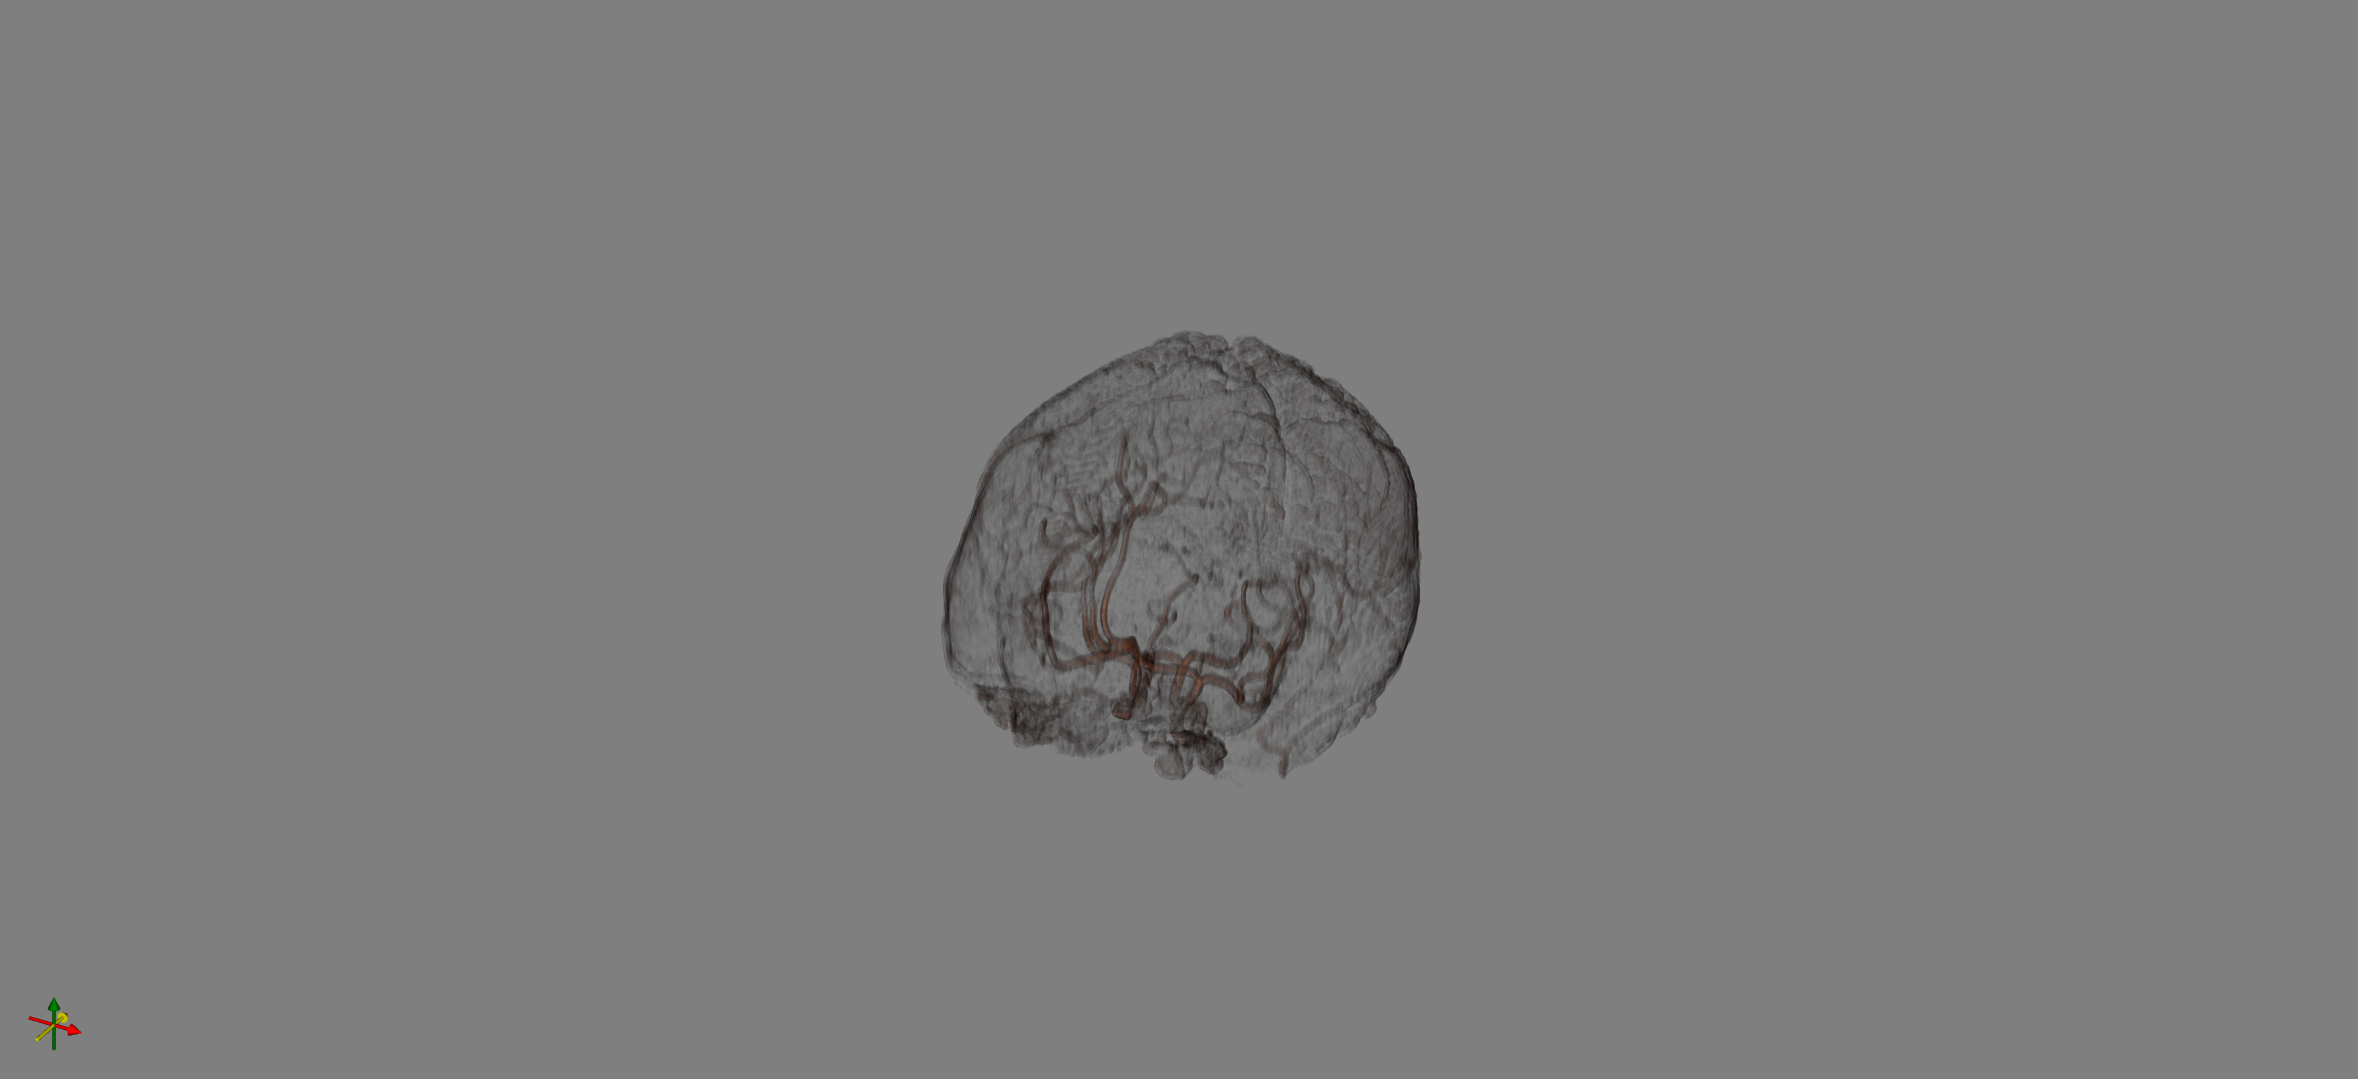

<IPython.core.display.Javascript object>

In [9]:
view(imDoGArray)

In [10]:
# We idetnify 25 seeds that are dispersed throughout the image
#    The brightest voxel is chosen as the first seed point
#    Once a seed point is chosen, the voxels around it are set to 0, to 
#       ensure that seed points are dispersed throughout the image
numSeeds = 25
seedCoverage = 20
seedCoord = np.zeros([numSeeds,3])
for i in range(numSeeds):
    seedCoord[i] = np.unravel_index(np.argmax(imDoGArray, axis=None), imDoGArray.shape)
    indx = [int(seedCoord[i][0]),int(seedCoord[i][1]),int(seedCoord[i][2])]
    minX = max(indx[0]-seedCoverage,0)
    maxX = min(indx[0]+seedCoverage,imDoGArray.shape[0])
    minY = max(indx[1]-seedCoverage,0)
    maxY = min(indx[1]+seedCoverage,imDoGArray.shape[1])
    minZ = max(indx[2]-seedCoverage,0)
    maxZ = min(indx[2]+seedCoverage,imDoGArray.shape[2])
    imDoGArray[minX:maxX,minY:maxY,minZ:maxZ]=im_min
    indx.reverse()
    seedCoord[:][i] = im.TransformIndexToPhysicalPoint(indx)
print(seedCoord)

[[  8.67799  -15.323692 -25.04051 ]
 [ -7.698968 -42.1987    12.332548]
 [ 36.812764 -19.942834  -5.304176]
 [ -3.499748 -54.79636   11.072782]
 [-11.478266 -30.020962 -36.378404]
 [ 37.652608  -6.085408   0.994654]
 [ 22.955338 -22.042444   8.55325 ]
 [ 33.87331   -8.60494   -7.823708]
 [ -3.499748 -33.80026  -21.261212]
 [ -3.079826 -30.860806 -11.603006]
 [ -1.400138  -4.40572  -27.560042]
 [ 38.912374 -30.020962 -12.862772]
 [ -2.659904 -37.99948   -2.784644]
 [ -8.538812 -31.70065   48.44584 ]
 [-12.31811  -16.163536 -26.720198]
 [ 29.254168 -25.821742 -16.64207 ]
 [-46.331792 -29.181118  -7.823708]
 [-41.71265    5.672408 -10.34324 ]
 [-20.296628  13.231004 -26.300276]
 [  7.418224  -3.145954 -25.04051 ]
 [ -8.11889  -25.821742  37.107946]
 [ 11.197522 -32.120572 -35.118638]
 [ 25.47487   30.447806   0.994654]
 [ 24.215104  -4.825642   9.813016]
 [ 53.189722  -8.60494   12.332548]]


In [11]:
# Use the seed points to extract "typical" vessels using very tolerant criteria (roundness, ridgeness, etc).
# The extracted vessels will be used to train/learn characteristics of the vessels in this image.   Those
# characteristics will then be used to create parzen density functions that provide estimates of probability
# of being a vessel or not...

# First, extract the "typical" vessels based on the chosen 25 seed points
vSeg = tube.SegmentTubes.New(Input=imDoG)
#vSeg.SetVerbose(True)
vSeg.SetMinRoundness(0.1)
vSeg.SetMinRidgeness(0.8)
vSeg.SetMinCurvature(0.001)  # This is the most influential variable - depends on intensity range of data
vSeg.SetRadiusInObjectSpace( 0.5 )
vSeg.SetMinLength(300)
for i in range(numSeeds):
    print("**** Processing seed " + str(i) + " : " + str(seedCoord[i]))
    vSeg.ExtractTubeInObjectSpace( seedCoord[i], i )
    
tubeMaskImage = vSeg.GetTubeMaskImage()

**** Processing seed 0 : [  8.67799  -15.323692 -25.04051 ]
**** Processing seed 1 : [ -7.698968 -42.1987    12.332548]
**** Processing seed 2 : [ 36.812764 -19.942834  -5.304176]
**** Processing seed 3 : [ -3.499748 -54.79636   11.072782]
**** Processing seed 4 : [-11.478266 -30.020962 -36.378404]
**** Processing seed 5 : [37.652608 -6.085408  0.994654]
**** Processing seed 6 : [ 22.955338 -22.042444   8.55325 ]
**** Processing seed 7 : [33.87331  -8.60494  -7.823708]
**** Processing seed 8 : [ -3.499748 -33.80026  -21.261212]
**** Processing seed 9 : [ -3.079826 -30.860806 -11.603006]
**** Processing seed 10 : [ -1.400138  -4.40572  -27.560042]
**** Processing seed 11 : [ 38.912374 -30.020962 -12.862772]
**** Processing seed 12 : [ -2.659904 -37.99948   -2.784644]
**** Processing seed 13 : [ -8.538812 -31.70065   48.44584 ]
**** Processing seed 14 : [-12.31811  -16.163536 -26.720198]
**** Processing seed 15 : [ 29.254168 -25.821742 -16.64207 ]
**** Processing seed 16 : [-46.331792 -2

In [12]:
itk.imwrite(tubeMaskImage, OutputBaseName+"-VesselsInitial.mha")

In [13]:
# Then create a training mask - with voxels inside the typical vessels labeled as vessel
#   voxels and voxels just beyond the boundary of the typical voxels labaled as background
LabelMapType = itk.Image[itk.UC,3]

trMask = tube.ComputeTrainingMask[ImageType,LabelMapType].New()
trMask.SetInput( tubeMaskImage )
trMask.SetGap( 3 )
trMask.SetObjectWidth( 1 )
trMask.SetNotObjectWidth( 1 )
trMask.Update()
fgMask = trMask.GetOutput()

In [14]:
itk.imwrite(fgMask, OutputBaseName+"-VesselsInitialMask.mha")

In [15]:
# Using the voxel/background mask, used parzen windowing and multi-scale intensity features
#   to build probability density functions representing vessel and background distributions.
#   Use those distributions to compute the probability of vessel and probability of background
#   at every voxel in the image.
enhancer = tube.EnhanceTubesUsingDiscriminantAnalysis[ImageType,LabelMapType].New()
enhancer.AddInput(imDoG)
enhancer.SetLabelMap(fgMask)
enhancer.SetRidgeId(255)
enhancer.SetBackgroundId(128)
enhancer.SetUnknownId(0)
enhancer.SetTrainClassifier(True)
enhancer.SetUseIntensityOnly(True)
enhancer.SetUseFeatureMath(True)
enhancer.SetScales([0.5*spacing, 1.0*spacing, 2.5*spacing])  #assumes vessels are near the resolution of the image
enhancer.Update()
enhancer.ClassifyImages()

In [16]:
prob0 = enhancer.GetClassProbabilityImage(0)
prob1 = enhancer.GetClassProbabilityImage(1)

#  Smooth the probability of background and probability of vessel images to reduce noise
#imMath.SetInput(enhancer.GetClassProbabilityImage(0))
#imMath.Blur(0.5*spacing)
#prob0 = imMath.GetOutput()
#imMath.SetInput(enhancer.GetClassProbabilityImage(1))
#imMath.Blur(0.5*spacing)
#prob1 = imMath.GetOutput()

In [17]:
itk.imwrite(prob0, OutputBaseName+"-Prob0.mha")
itk.imwrite(prob1, OutputBaseName+"-Prob1.mha")

In [18]:
#  The difference between probability of vessel and probability of background gives a relative
#     estimate of vessels-ness at every voxel - we call this the vessel-enhanced image.
imMath.SetInput(prob0)
imMath.AddImages(prob1, 1, -1)
diff = imMath.GetOutput()
diffArr = itk.GetArrayFromImage(diff)
dMax = diffArr.max()
probArr = diffArr / dMax

imMath.SetInput(im)
imMath.Threshold(0.000001,10000,1,0)
imMath.Erode(10,1,0)
brainMask = imMath.GetOutput()
brainMaskArr = itk.GetArrayFromImage(brainMask)

probArrMasked = brainMaskArr * probArr

In [19]:
imVessRaw = itk.GetImageFromArray(probArrMasked)
imVessRaw.CopyInformation(im)

imMath.SetInput(imVessRaw)
#imMath.MedianFilter(1)
imMath.IntensityWindow(0,1,0,1)
imVess = imMath.GetOutput()


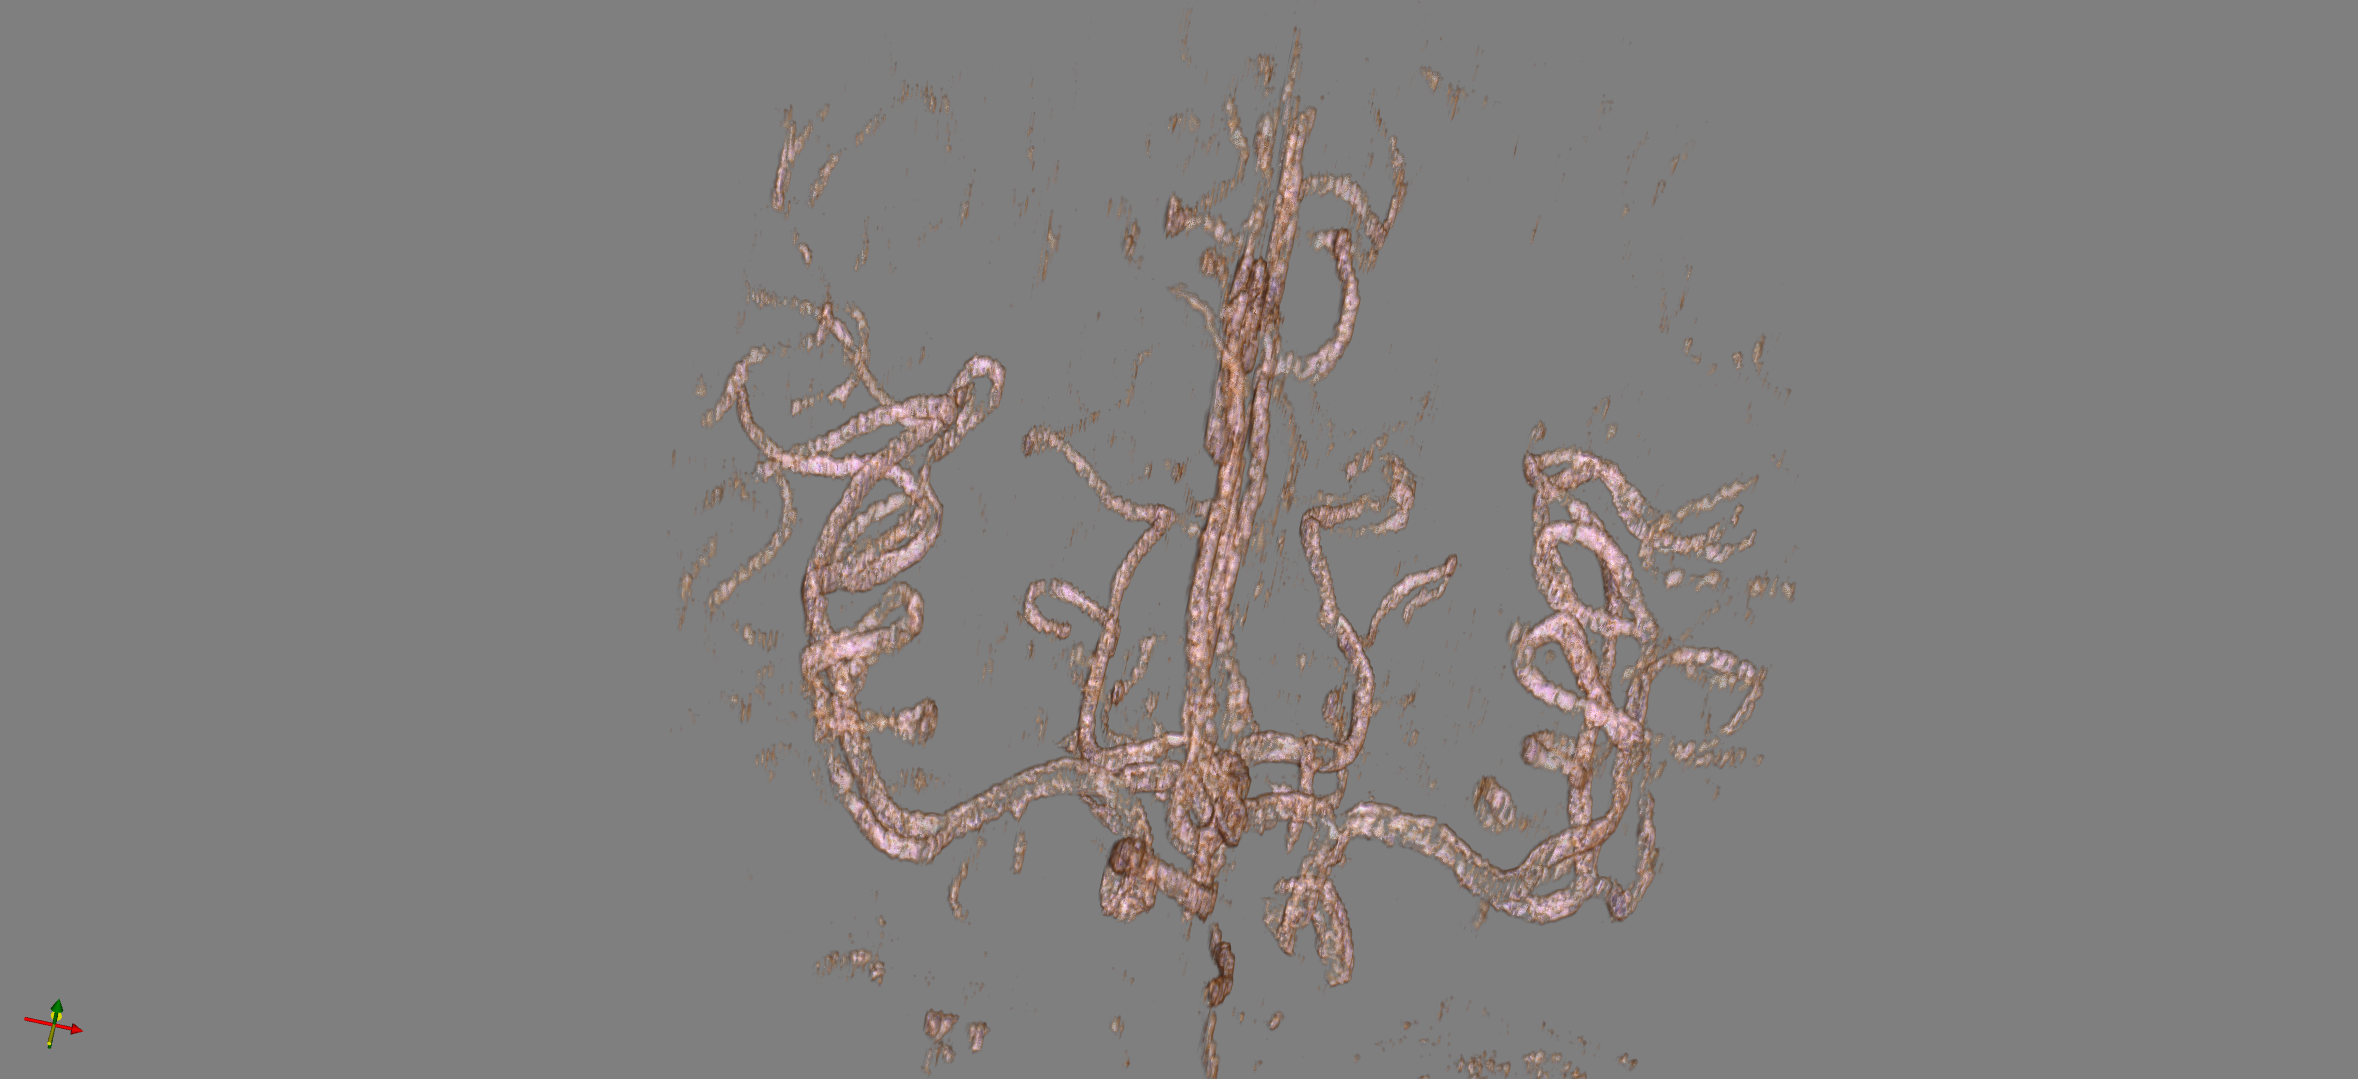
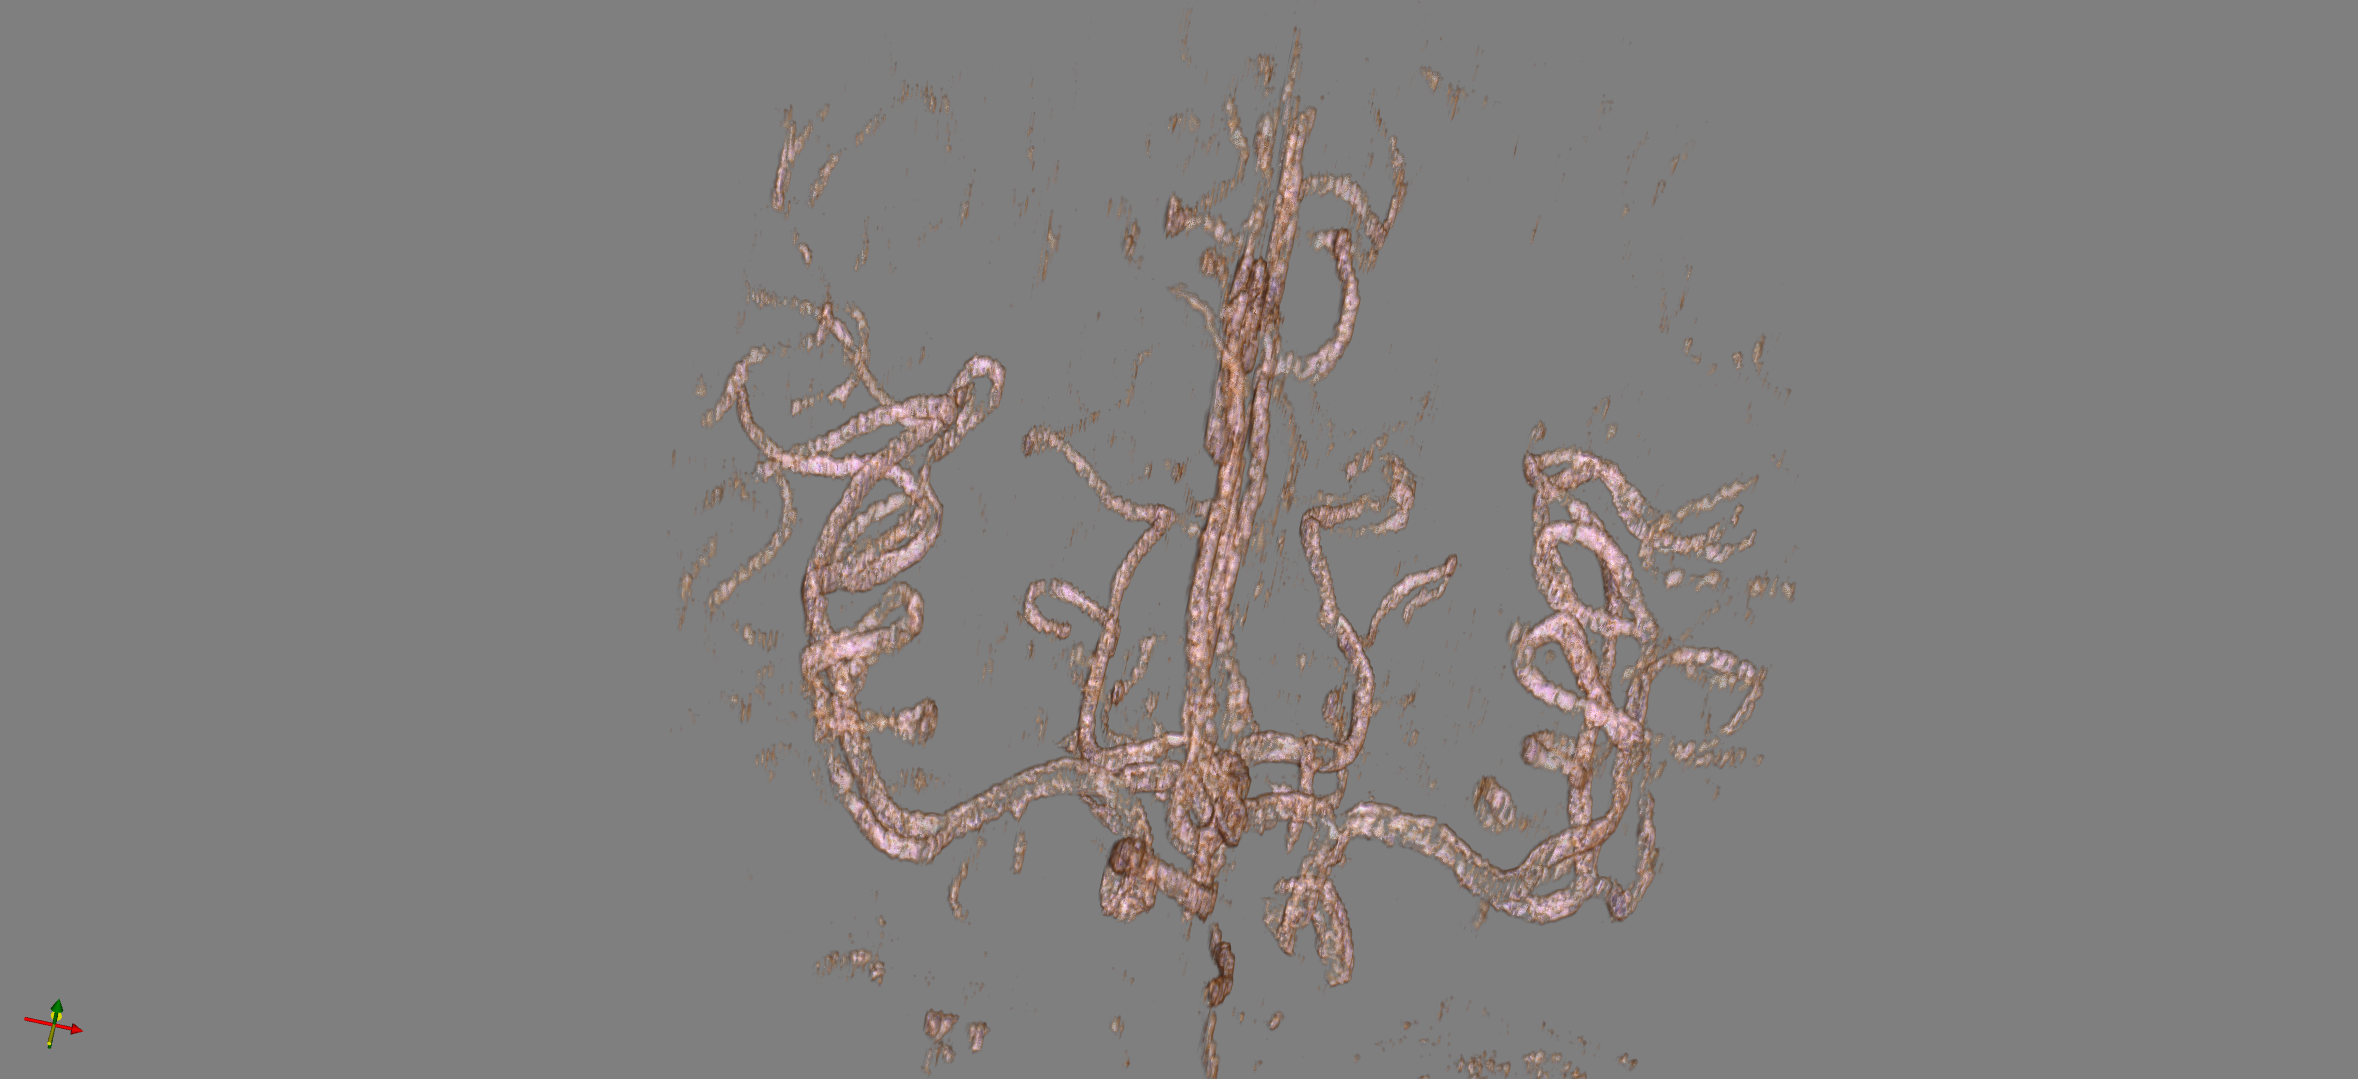

<IPython.core.display.Javascript object>

In [20]:
view(imVess)

In [21]:
itk.imwrite( imVess, OutputBaseName+"-VesselsEnhanced.mha", compression=True)

In [22]:
# Find the voxels for which vesselsness is > epsilon
imMath = tube.ImageMath.New(imVess)
imMath.MedianFilter(1)
imMath.Threshold(0.000001, 1, 1, 0)
imVessMask = imMath.GetOutputShort()

itk.imwrite(imVessMask, OutputBaseName+"-VesselSeedsInitialMask0.mha")

# Keep large (greater than 100 voxels) collections of connected vessel
#   voxels as potential voxels to be included in vessel models.
ccSeg = tube.SegmentConnectedComponents.New(imVessMask)
ccSeg.SetMinimumVolume(10)
ccSeg.Update()
imVessMask = ccSeg.GetOutput()

itk.imwrite(imVessMask,OutputBaseName+"-VesselSeedsInitialMask.mha")
imVessMask = itk.imread(OutputBaseName+"-VesselSeedsInitialMask.mha", itk.F)

In [23]:
# Create seeds out of those groups of connected vessel voxels.
#   Assumes that the background component has label 0
imMath.SetInput(imVess)
imMath.ReplaceValuesOutsideMaskRange(imVessMask,1,99999,0)
imSeeds = imMath.GetOutput()
itk.imwrite(imSeeds,OutputBaseName+"-VesselSeeds.mha")

In [24]:
# Here we generate initial guesses of the vessel radii by computing
#   a distance map using the connected vessel-voxel groups
imMath.SetInput(imVessMask)
imMath.Threshold(0,1,1,0)
imVessMaskInv = imMath.GetOutput()

distFilter = itk.DanielssonDistanceMapImageFilter.New(imVessMaskInv)
distFilter.Update()
dist = distFilter.GetOutput()

imMath.SetInput(dist)
imMath.Blur(0.4*spacing)
tmp = imMath.GetOutput()
imMath.ReplaceValuesOutsideMaskRange(tmp, 0.1, 10, 0)
imSeedsRadius = imMath.GetOutput()

itk.imwrite(imSeedsRadius, OutputBaseName+"-VesselSeedsRadius.mha")

In [25]:
# For the input to the vessel extraction method, we'll slightly blur the input image.
#   And we will zero-out all voxel values that had insufficient vesselness
imMath.SetInput(im)
#imMath.ReplaceValuesOutsideMaskRange(imVessMask, 1, 99999, 0)
#
imMath.Blur(spacing)
imInput = imMath.GetOutput()

itk.imwrite(imInput,OutputBaseName+"-VesselInput.mha")

In [26]:
# For the demo, we'll try to extract at most 500 vessels
numSeeds = 5000

vSeg = tube.SegmentTubes.New(Input=imInput)
#vSeg.SetVerbose(True)
vSeg.SetMinCurvature(0.00001)  # This is typically the most influential parameter
vSeg.SetMinCurvatureStart(0)
vSeg.SetMinRoundness(0.1)
vSeg.SetMinRoundnessStart(0)
vSeg.SetMinRidgeness(0.75)
vSeg.SetMinRidgenessStart(0.5)
vSeg.SetMinLevelness(0.0)
vSeg.SetMinLevelnessStart(0)
vSeg.SetRadiusInObjectSpace( spacing )
vSeg.SetBorderInIndexSpace(3)
vSeg.SetSeedMask( imSeeds )
vSeg.SetSeedRadiusMask( imSeedsRadius )
vSeg.SetOptimizeRadius(True)
vSeg.SetSeedMaskMaximumNumberOfPoints(numSeeds)
vSeg.SetUseSeedMaskAsProbabilities(True)
vSeg.SetSeedExtractionMinimumProbability(0.0001)
vSeg.SetMinLength(300)
vSeg.ProcessSeeds()

In [27]:
#Save the results in various formats

tubeMaskImage = vSeg.GetTubeMaskImage()
itk.imwrite(tubeMaskImage,OutputBaseName+"-Vessels"+str(numSeeds)+".mha")


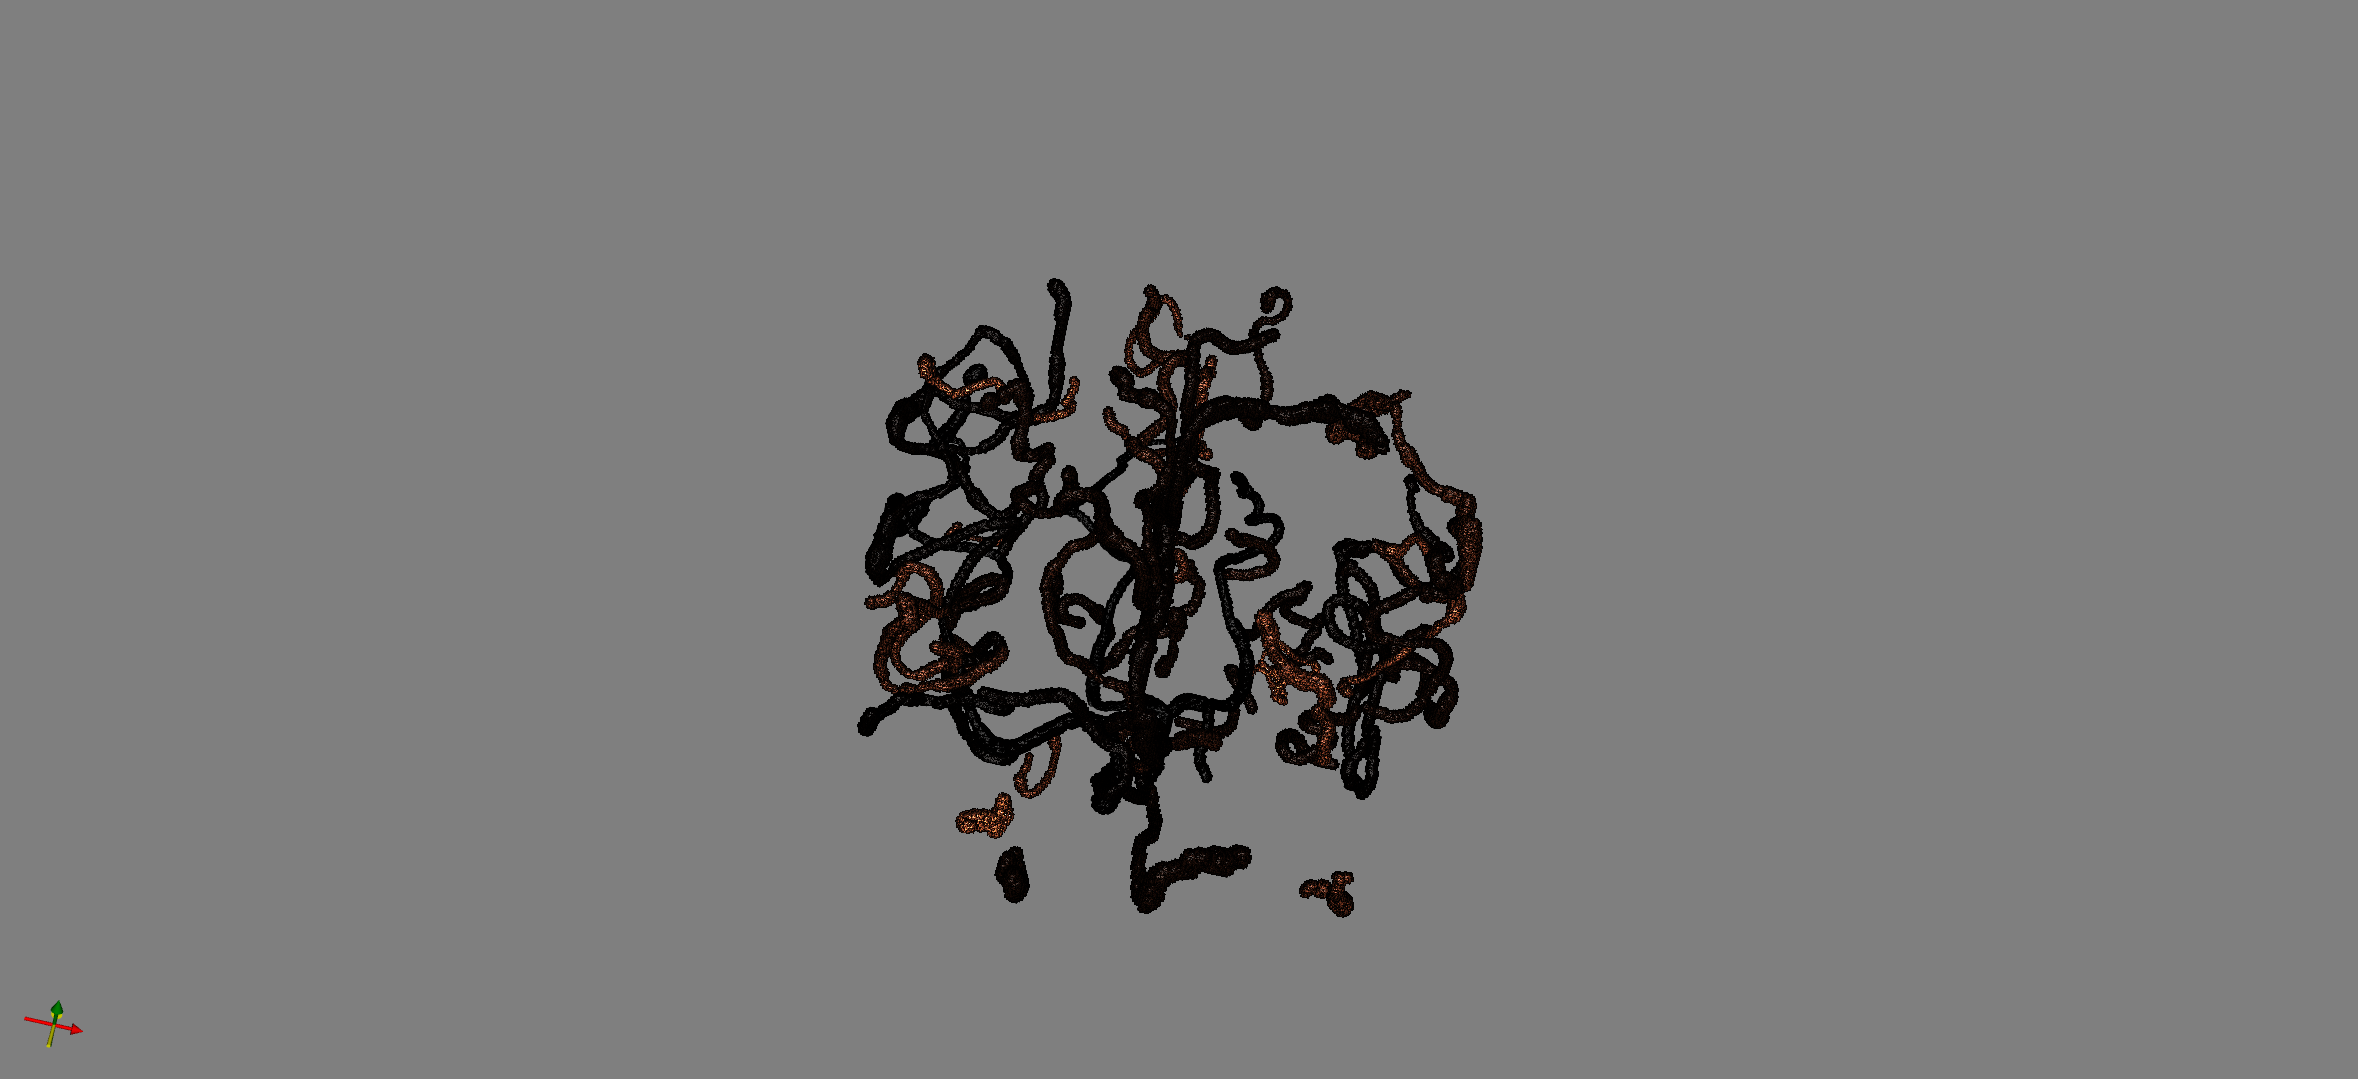
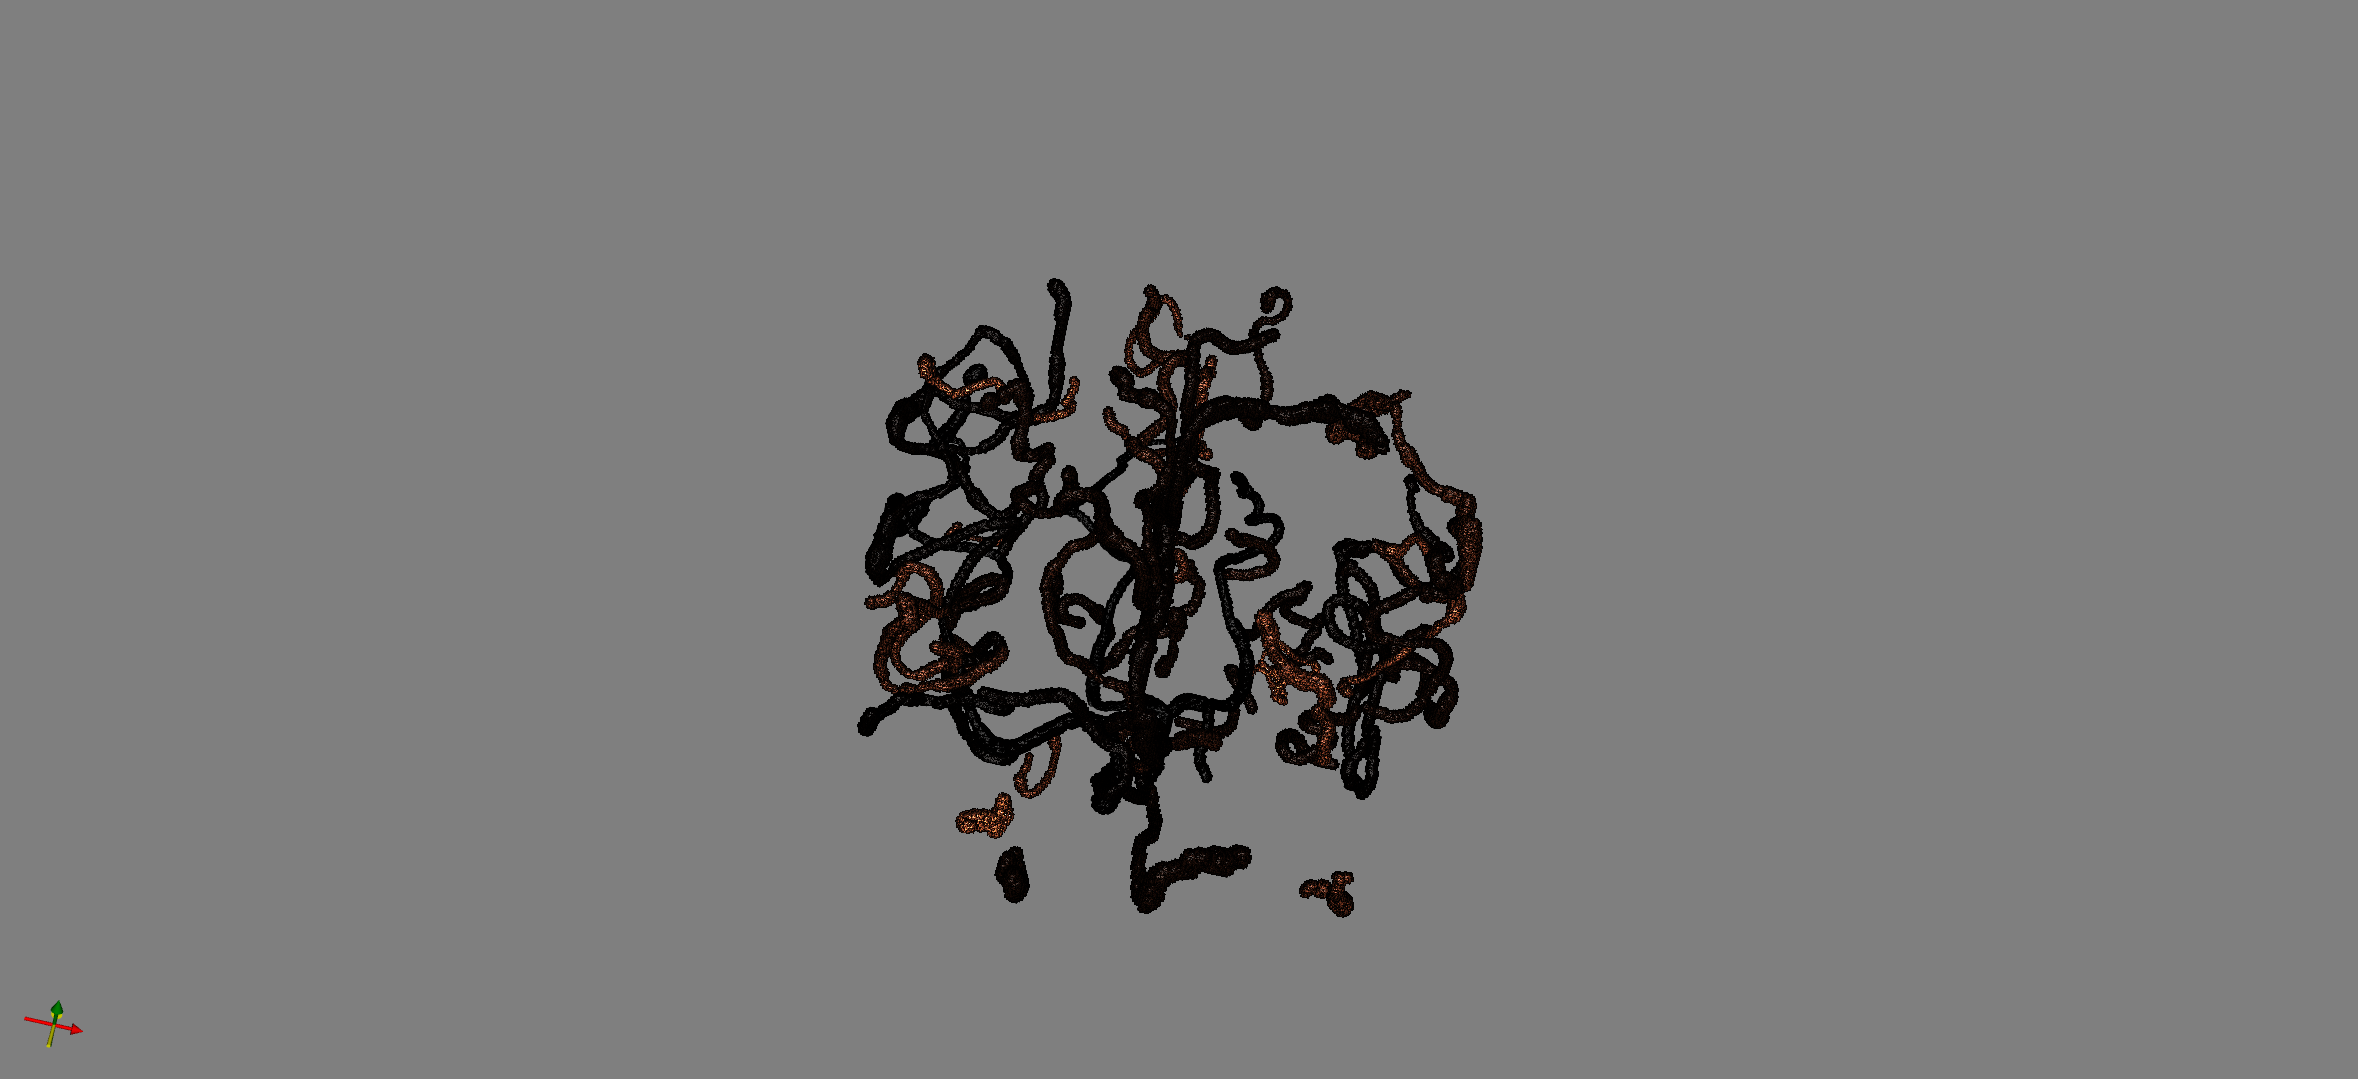

<IPython.core.display.Javascript object>

In [32]:
view(tubeMaskImage)

In [29]:
# smooth tubes!
TubeMath = tube.TubeMath[3, itk.F].New()
TubeMath.SetInputTubeGroup(vSeg.GetTubeGroup())
TubeMath.SetUseAllTubes()
TubeMath.SmoothTube(4,"SMOOTH_TUBE_USING_INDEX_GAUSSIAN")
TubeMath.SmoothTubeProperty("Radius",2,"SMOOTH_TUBE_USING_INDEX_GAUSSIAN")
tubes = TubeMath.GetOutputTubeGroup()

In [30]:
SOWriter = itk.SpatialObjectWriter[3].New()
SOWriter.SetInput(vSeg.GetTubeGroup())
SOWriter.SetBinaryPoints(True)
SOWriter.SetFileName(OutputBaseName+"-Vessels"+str(numSeeds)+".tre")
SOWriter.Update()

In [31]:
ConvSurface = tube.WriteTubesAsPolyData.New()
ConvSurface.SetInput(tubes)
ConvSurface.SetFileName(OutputBaseName+"-Vessels"+str(numSeeds)+".vtp")
ConvSurface.Update()